# Architecture-Based Tenant Replication with Configuration Coherence

This notebook demonstrates the **configuration-coherent** architecture-based replication workflow:

1. **Pattern Detection**: Analyze source tenant and detect architectural patterns
2. **Configuration-Coherent Instance Selection**: Select instances with similar resource configurations
3. **Target Graph Building**: Build target pattern graph from selected instances
4. **Visualization & Comparison**: Compare source vs target graphs

## Key Concepts

- **Pattern Graph**: Type-level aggregation of the instance resource graph
- **Configuration-Coherent Instances**: Groups of resources with similar configurations (location, SKU tier, tags)
- **Weighted Similarity**: Location (50%), SKU tier (30%), Tags (20%)
- **Goal**: Build target pattern graph that MATCHES source pattern graph structure AND configuration distributions
- **Spectral Distance**: Mathematical measure of structural similarity (lower = better)

## Configuration Coherence

Resources within each instance have **similar configurations**:
- Same Azure region (location)
- Similar SKU tier (Standard, Premium, Basic)
- Overlapping tags

This ensures replicated tenants match both **architectural structure** AND **configuration characteristics**.

## Setup

In [1]:
import os
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

sys.path.insert(0, str(Path.cwd().parent))

# Force reload the module to pick up any code changes
import importlib

if "src.architecture_based_replicator" in sys.modules:
    importlib.reload(sys.modules["src.architecture_based_replicator"])

from src.architecture_based_replicator import ArchitecturePatternReplicator

# Set up matplotlib
plt.style.use("seaborn-v0_8-darkgrid")
%matplotlib inline

# Verify the fix is in the code
import inspect

source_code = inspect.getsource(
    ArchitecturePatternReplicator._build_target_pattern_graph_from_instances
)
if "First, add ALL resource types from selected instances as nodes" in source_code:
    print("✅ Setup complete - Fix #2 is present in loaded code")
else:
    print("⚠️  Setup complete - WARNING: Fix #2 NOT FOUND in loaded code")
    print("   You may need to restart the kernel")

✅ Setup complete - Fix #2 is present in loaded code


## Configuration

In [2]:
NEO4J_URI = os.getenv("NEO4J_URI", "bolt://localhost:7687")
NEO4J_USER = os.getenv("NEO4J_USER", "neo4j")
NEO4J_PASSWORD = os.getenv("NEO4J_PASSWORD", "neo4j123")

# Number of instances to select for demonstration
# Higher values = better node coverage but slower execution
# Recommended values:
#   - 10:  Quick demo (~18% node coverage, ~14% edge coverage)
#   - 50:  Good balance (~47% node coverage, ~40% edge coverage)
#   - 100: High coverage (~65% node coverage, ~60% edge coverage)
#   - None: All instances (100% coverage)
TARGET_INSTANCE_COUNT = 500

print(f"Neo4j URI: {NEO4J_URI}")
print(f"Target instance count: {TARGET_INSTANCE_COUNT}")

Neo4j URI: bolt://localhost:7687
Target instance count: 500


---
# Part 1: Pattern Detection & Instance Selection
---

## Step 1: Analyze Source Tenant with Configuration Coherence

**How this works**:
1. Queries the **instance resource graph** (all individual resources in Neo4j)
2. Aggregates instance relationships by resource type
3. Creates **pattern graph** (type-level view)
4. Detects which architectural patterns exist in the pattern graph
5. Finds **configuration-coherent instances** by:
   - Grouping resources by ResourceGroup
   - Computing configuration similarity (location, SKU tier, tags)
   - Splitting ResourceGroups into coherent clusters using agglomerative clustering

**Configuration Coherence**: Resources need 50%+ similarity to be in same instance (location 50%, SKU tier 30%, tags 20%)

In [3]:
replicator = ArchitecturePatternReplicator(
    neo4j_uri=NEO4J_URI, neo4j_user=NEO4J_USER, neo4j_password=NEO4J_PASSWORD
)

print("🔍 Analyzing source tenant with configuration coherence...")

# Enable configuration coherence by default
analysis = replicator.analyze_source_tenant(
    use_configuration_coherence=True,
    coherence_threshold=0.5,  # Resources need 50%+ similarity
)

print("\n📊 Source Tenant:")
print(f"   Resource Types: {analysis['resource_types']}")
print(f"   Pattern Graph Edges: {analysis['pattern_graph_edges']}")
print(f"   Detected Patterns: {analysis['detected_patterns']}")
print(f"   Total Pattern Instances: {analysis.get('total_pattern_resources', 0)}")
print("   Configuration Coherence: ✓ ENABLED (threshold: 0.5)")

print("\n📐 Detected Architectural Patterns (Config-Coherent Instances):")
for pattern_name, pattern_info in replicator.detected_patterns.items():
    instances = replicator.pattern_resources.get(pattern_name, [])
    total_resources = sum(len(instance) for instance in instances)
    print(f"  {pattern_name}:")
    print(f"    Config-Coherent Instances: {len(instances)}")
    print(f"    Total Resources: {total_resources}")
    print(f"    Completeness: {pattern_info['completeness']:.1%}")
    if instances:
        avg_size = total_resources / len(instances)
        print(f"    Avg Instance Size: {avg_size:.1f} resources")

🔍 Analyzing source tenant with configuration coherence...

📊 Source Tenant:
   Resource Types: 85
   Pattern Graph Edges: 276
   Detected Patterns: 10
   Total Pattern Instances: 535
   Configuration Coherence: ✓ ENABLED (threshold: 0.5)

📐 Detected Architectural Patterns (Config-Coherent Instances):
  Web Application:
    Config-Coherent Instances: 60
    Total Resources: 90
    Completeness: 10000.0%
    Avg Instance Size: 1.5 resources
  Virtual Machine Workload:
    Config-Coherent Instances: 77
    Total Resources: 148
    Completeness: 10000.0%
    Avg Instance Size: 1.9 resources
  Container Platform:
    Config-Coherent Instances: 68
    Total Resources: 68
    Completeness: 7500.0%
    Avg Instance Size: 1.0 resources
  Data Platform:
    Config-Coherent Instances: 51
    Total Resources: 71
    Completeness: 10000.0%
    Avg Instance Size: 1.4 resources
  Serverless Application:
    Config-Coherent Instances: 74
    Total Resources: 117
    Completeness: 10000.0%
    Avg Inst

## Step 2: Analyze Source Orphaned Nodes 🔍

**NEW**: Before selecting instances, identify resource types in the source graph that aren't covered by any detected pattern. This helps us decide whether to include orphaned node instances in our replication plan.

In [4]:
# Analyze orphaned nodes in SOURCE graph before building target
print("🔍 Analyzing orphaned nodes in source graph...\n")

# Identify orphaned nodes in source (nodes not covered by any detected pattern)
source_orphaned = replicator.analyzer.identify_orphaned_nodes(
    replicator.source_pattern_graph, replicator.detected_patterns
)

print("📊 Source Orphaned Node Analysis:")
print(f"   Total orphaned types in source: {len(source_orphaned)}")

if source_orphaned:
    print("\n📋 Top 10 Orphaned Types in Source (not in any pattern):")
    for idx, node in enumerate(source_orphaned[:10], 1):
        print(
            f"  {idx:2d}. {node['resource_type']:40s} : {node['connection_count']:5d} connections, degree {node['total_degree']:3d}"
        )

    # Get pattern suggestions
    suggested_patterns = replicator.analyzer.suggest_new_patterns(
        source_orphaned, replicator.source_pattern_graph
    )

    if suggested_patterns:
        print("\n💡 Pattern Suggestions to Improve Coverage:")
        print(f"   Total suggestions: {len(suggested_patterns)}")

        high_confidence = [
            p for p in suggested_patterns if p.get("confidence", 0) > 0.5
        ]
        if high_confidence:
            print(f"   High-confidence suggestions: {len(high_confidence)}")
            print("\n🏆 Top 3 High-Confidence Suggestions:\n")

            for idx, pattern in enumerate(high_confidence[:3], 1):
                print(f"{idx}. {pattern['suggested_name']}")
                print(f"   Confidence: {pattern.get('confidence', 0.0):.2f}")

                if pattern.get("action") == "UPDATE_EXISTING":
                    print(
                        f"   Action: Add '{pattern['resource_to_add']}' to '{pattern['target_pattern']}'"
                    )
                else:
                    req = pattern.get("required_resources", [])
                    print(f"   New pattern with: {', '.join(req[:5])}")
                print()

    print("\n💡 Replication Strategy:")
    print("   We will include orphaned node instances in the replication plan")
    print("   to ensure these resource types are captured in the target graph.")
else:
    print(
        "\n✅ No orphaned nodes found - all resource types are covered by detected patterns!"
    )

🔍 Analyzing orphaned nodes in source graph...

📊 Source Orphaned Node Analysis:
   Total orphaned types in source: 61

📋 Top 10 Orphaned Types in Source (not in any pattern):
   1. roleAssignments                          :  3821 connections, degree   6
   2. Subscription                             :  3489 connections, degree  78
   3. ResourceGroup                            :  3155 connections, degree  78
   4. Region                                   :  2215 connections, degree  76
   5. Tag                                      :  1464 connections, degree  39
   6. User                                     :  1457 connections, degree   3
   7. ServicePrincipal                         :   574 connections, degree   1
   8. publicIPAddresses                        :   522 connections, degree   4
   9. virtualMachineScaleSets                  :   411 connections, degree   4
  10. extensions                               :   360 connections, degree   3

💡 Pattern Suggestions to Improve C

---
# Part 2: Architecture Distribution-Based Replication
---

This section demonstrates **proportional tenant replication** with all features enabled:
- ✅ Architecture distribution analysis
- ✅ Configuration coherence
- ✅ Orphaned node inclusion

## Step 3: Generate Replication Plan

Generate a replication plan using **architecture distribution-based proportional allocation** with configuration coherence and orphaned node inclusion.

In [5]:
print(
    f"🔨 Generating replication plan for {TARGET_INSTANCE_COUNT} architectural instances...\n"
)

# Generate plan with ALL features enabled
selected_pattern_instances, spectral_history, distribution_metadata = (
    replicator.generate_replication_plan(
        target_instance_count=TARGET_INSTANCE_COUNT,
        hops=2,
        include_orphaned_node_patterns=True,  # ✅ Include orphaned nodes
        use_architecture_distribution=True,  # ✅ Proportional allocation
        use_configuration_coherence=True,  # ✅ Config-coherent selection
    )
)

print("\n✅ Replication plan complete!")
print(f"   Selection mode: {distribution_metadata.get('selection_mode', 'unknown')}")

# Count resources
total_resources = 0
orphaned_pattern_count = 0
for pattern_name, instances in selected_pattern_instances:
    if pattern_name.startswith("Orphaned:"):
        orphaned_pattern_count += len(instances)
    for instance in instances:
        total_resources += len(instance)

total_instances = sum(len(instances) for _, instances in selected_pattern_instances)

print(f"   Total instances selected: {total_instances}")
print(f"   Total resources: {total_resources}")
if orphaned_pattern_count > 0:
    print(f"   Orphaned node instances: {orphaned_pattern_count}")

# Build target pattern graph
print("\n🔍 Building target pattern graph...")
flattened_instances = []
for pattern_name, instances in selected_pattern_instances:
    for instance in instances:
        flattened_instances.append((pattern_name, instance))

target_pattern_graph = replicator._build_target_pattern_graph_from_instances(
    flattened_instances
)

print(
    f"   Target: {target_pattern_graph.number_of_nodes()} types, {target_pattern_graph.number_of_edges()} edges"
)
print(
    f"   Source: {replicator.source_pattern_graph.number_of_nodes()} types, {replicator.source_pattern_graph.number_of_edges()} edges"
)

🔨 Generating replication plan for 500 architectural instances...



Validation: Target distribution is statistically indistinguishable from source



✅ Replication plan complete!
   Selection mode: proportional
   Total instances selected: 488
   Total resources: 672

🔍 Building target pattern graph...
   Target: 20 types, 58 edges
   Source: 85 types, 276 edges


---
# Part 3: Comprehensive Comparison Visualizations
---

## Visualization 1: Architecture Distribution Comparison 📊

Compare the **normalized distribution** of architectural pattern instances between source and target tenants.

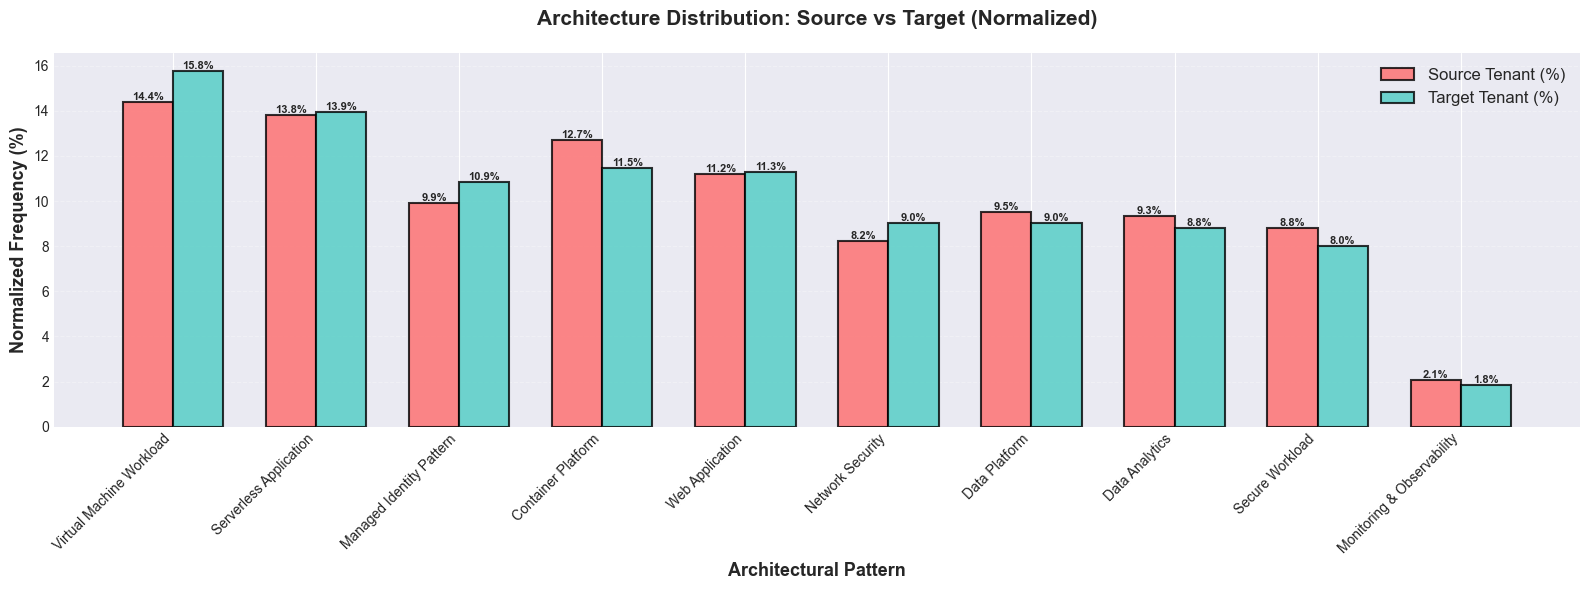


📊 Distribution Statistics:
   Source total: 535 instances
   Target total: 488 instances (91.2% of source)

💡 Interpretation:
   Bars should align in height to indicate proportional replication.
   The target maintains the architectural balance of the source.


In [6]:
if distribution_metadata and "architecture_distribution" in distribution_metadata:
    distribution_scores = distribution_metadata["architecture_distribution"]
    actual_counts = distribution_metadata.get("actual_counts", {})

    # Prepare data - sorted by source distribution score
    pattern_names = []
    source_instances = []
    target_instances = []

    sorted_patterns = sorted(
        distribution_scores.items(),
        key=lambda x: x[1]["distribution_score"],
        reverse=True,
    )

    for pattern_name, data in sorted_patterns:
        pattern_names.append(pattern_name[:30])
        source_instances.append(data["source_instances"])
        target_instances.append(actual_counts.get(pattern_name, 0))

    # Calculate normalized percentages
    total_source = sum(source_instances)
    total_target = sum(target_instances)

    source_pct = np.array(
        [(c / total_source * 100) if total_source > 0 else 0 for c in source_instances]
    )
    target_pct = np.array(
        [(c / total_target * 100) if total_target > 0 else 0 for c in target_instances]
    )

    # Create figure
    fig, ax = plt.subplots(figsize=(16, 6))

    x = np.arange(len(pattern_names))
    width = 0.35

    bars1 = ax.bar(
        x - width / 2,
        source_pct,
        width,
        label="Source Tenant (%)",
        color="#ff6b6b",
        alpha=0.8,
        edgecolor="black",
        linewidth=1.5,
    )
    bars2 = ax.bar(
        x + width / 2,
        target_pct,
        width,
        label="Target Tenant (%)",
        color="#4ecdc4",
        alpha=0.8,
        edgecolor="black",
        linewidth=1.5,
    )

    ax.set_xlabel("Architectural Pattern", fontsize=13, fontweight="bold")
    ax.set_ylabel("Normalized Frequency (%)", fontsize=13, fontweight="bold")
    ax.set_title(
        "Architecture Distribution: Source vs Target (Normalized)",
        fontsize=15,
        fontweight="bold",
        pad=20,
    )
    ax.set_xticks(x)
    ax.set_xticklabels(pattern_names, rotation=45, ha="right", fontsize=10)
    ax.legend(fontsize=12, loc="upper right")
    ax.grid(axis="y", alpha=0.3, linestyle="--")

    # Add percentage labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            if height > 0.5:  # Only label bars > 0.5%
                ax.text(
                    bar.get_x() + bar.get_width() / 2.0,
                    height,
                    f"{height:.1f}%",
                    ha="center",
                    va="bottom",
                    fontsize=8,
                    fontweight="bold",
                )

    plt.tight_layout()
    plt.show()

    # Summary
    print("\n📊 Distribution Statistics:")
    print(f"   Source total: {total_source} instances")
    print(
        f"   Target total: {total_target} instances ({total_target / total_source * 100:.1f}% of source)"
    )

    # Calculate distribution similarity
    if (
        "validation" in distribution_metadata
        and "cosine_similarity" in distribution_metadata["validation"]
    ):
        sim = distribution_metadata["validation"]["cosine_similarity"]
        print(f"   Distribution similarity: {sim:.3f} (cosine similarity)")

    print("\n💡 Interpretation:")
    print("   Bars should align in height to indicate proportional replication.")
    print("   The target maintains the architectural balance of the source.")
else:
    print("⚠️  Enable architecture distribution to see this visualization")

## Visualization 2: Node Overlap Analysis 📊

Visualize which resource types are **common** vs **unique** between source and target pattern graphs.

📊 Node Overlap Analysis

   Common nodes: 20 (23.5% of source)
   Source-only nodes: 65
   Target-only nodes: 0


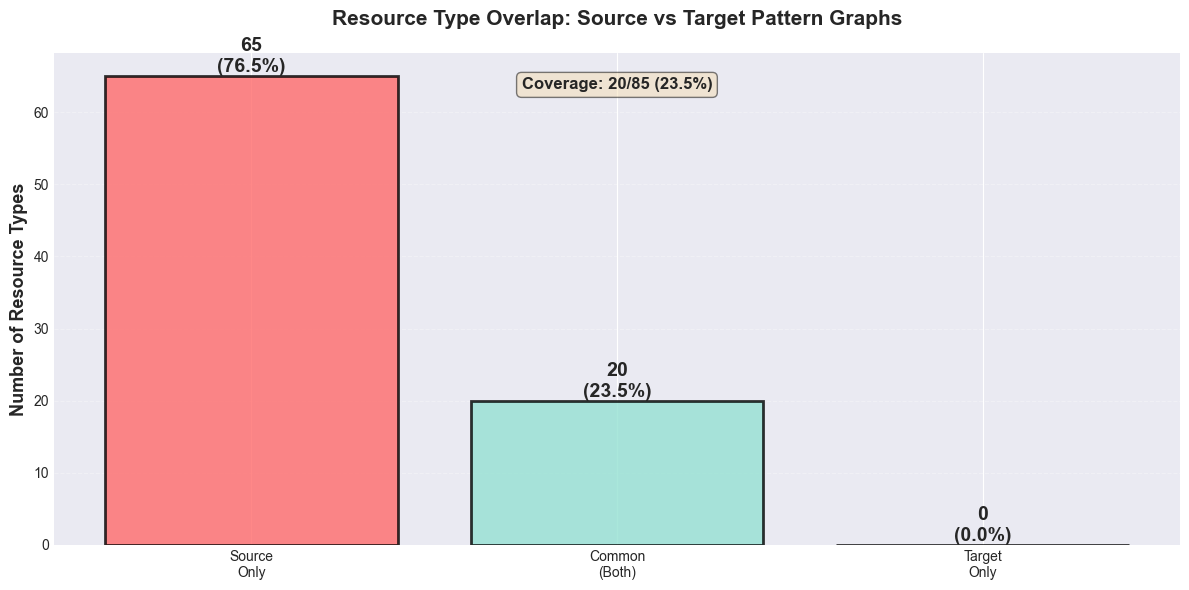


✅ Sample common nodes (10 of 20):
   • Region
   • ResourceGroup
   • Subscription
   • Tag
   • components
   • dataCollectionRules
   • disks
   • loadBalancers
   • managedClusters
   • networkInterfaces
   ... and 10 more

⚠️  Sample missing nodes (10 of 65):
   • CommunicationServices
   • Domains
   • EmailServices
   • IdentityGroup
   • Redis
   • ServicePrincipal
   • User
   • accessConnectors
   • accounts
   • actiongroups
   ... and 55 more


In [7]:
source_nodes = set(replicator.source_pattern_graph.nodes())
target_nodes = set(target_pattern_graph.nodes())

common_nodes = source_nodes.intersection(target_nodes)
source_only = source_nodes - target_nodes
target_only = target_nodes - source_nodes

print("📊 Node Overlap Analysis\n")
print(
    f"   Common nodes: {len(common_nodes)} ({len(common_nodes) / len(source_nodes) * 100:.1f}% of source)"
)
print(f"   Source-only nodes: {len(source_only)}")
print(f"   Target-only nodes: {len(target_only)}")

# Create Venn diagram visualization
fig, ax = plt.subplots(figsize=(12, 6))

categories = ["Source\nOnly", "Common\n(Both)", "Target\nOnly"]
counts = [len(source_only), len(common_nodes), len(target_only)]
colors = ["#ff6b6b", "#95e1d3", "#4ecdc4"]

bars = ax.bar(
    categories, counts, color=colors, alpha=0.8, edgecolor="black", linewidth=2
)

# Add value labels
for bar, count in zip(bars, counts):
    height = bar.get_height()
    percentage = count / (len(source_nodes) + len(target_only)) * 100
    ax.text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f"{count}\n({percentage:.1f}%)",
        ha="center",
        va="bottom",
        fontsize=14,
        fontweight="bold",
    )

ax.set_ylabel("Number of Resource Types", fontsize=13, fontweight="bold")
ax.set_title(
    "Resource Type Overlap: Source vs Target Pattern Graphs",
    fontsize=15,
    fontweight="bold",
    pad=20,
)
ax.grid(axis="y", alpha=0.3, linestyle="--")

# Add summary text
summary_text = f"Coverage: {len(common_nodes)}/{len(source_nodes)} ({len(common_nodes) / len(source_nodes) * 100:.1f}%)"
ax.text(
    0.5,
    0.95,
    summary_text,
    transform=ax.transAxes,
    ha="center",
    va="top",
    fontsize=12,
    fontweight="bold",
    bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5),
)

plt.tight_layout()
plt.show()

# List sample common and missing nodes
if common_nodes:
    common_list = sorted(list(common_nodes))[:10]
    print(f"\n✅ Sample common nodes ({len(common_list)} of {len(common_nodes)}):")
    for node in common_list:
        print(f"   • {node}")
    if len(common_nodes) > 10:
        print(f"   ... and {len(common_nodes) - 10} more")

if source_only:
    missing_list = sorted(list(source_only))[:10]
    print(f"\n⚠️  Sample missing nodes ({len(missing_list)} of {len(source_only)}):")
    for node in missing_list:
        print(f"   • {node}")
    if len(source_only) > 10:
        print(f"   ... and {len(source_only) - 10} more")

## Visualization 3: Pattern Graph Comparison 🔀

Side-by-side visualization of source and target pattern graphs.

📊 Visualizing top 30 nodes by degree from each graph



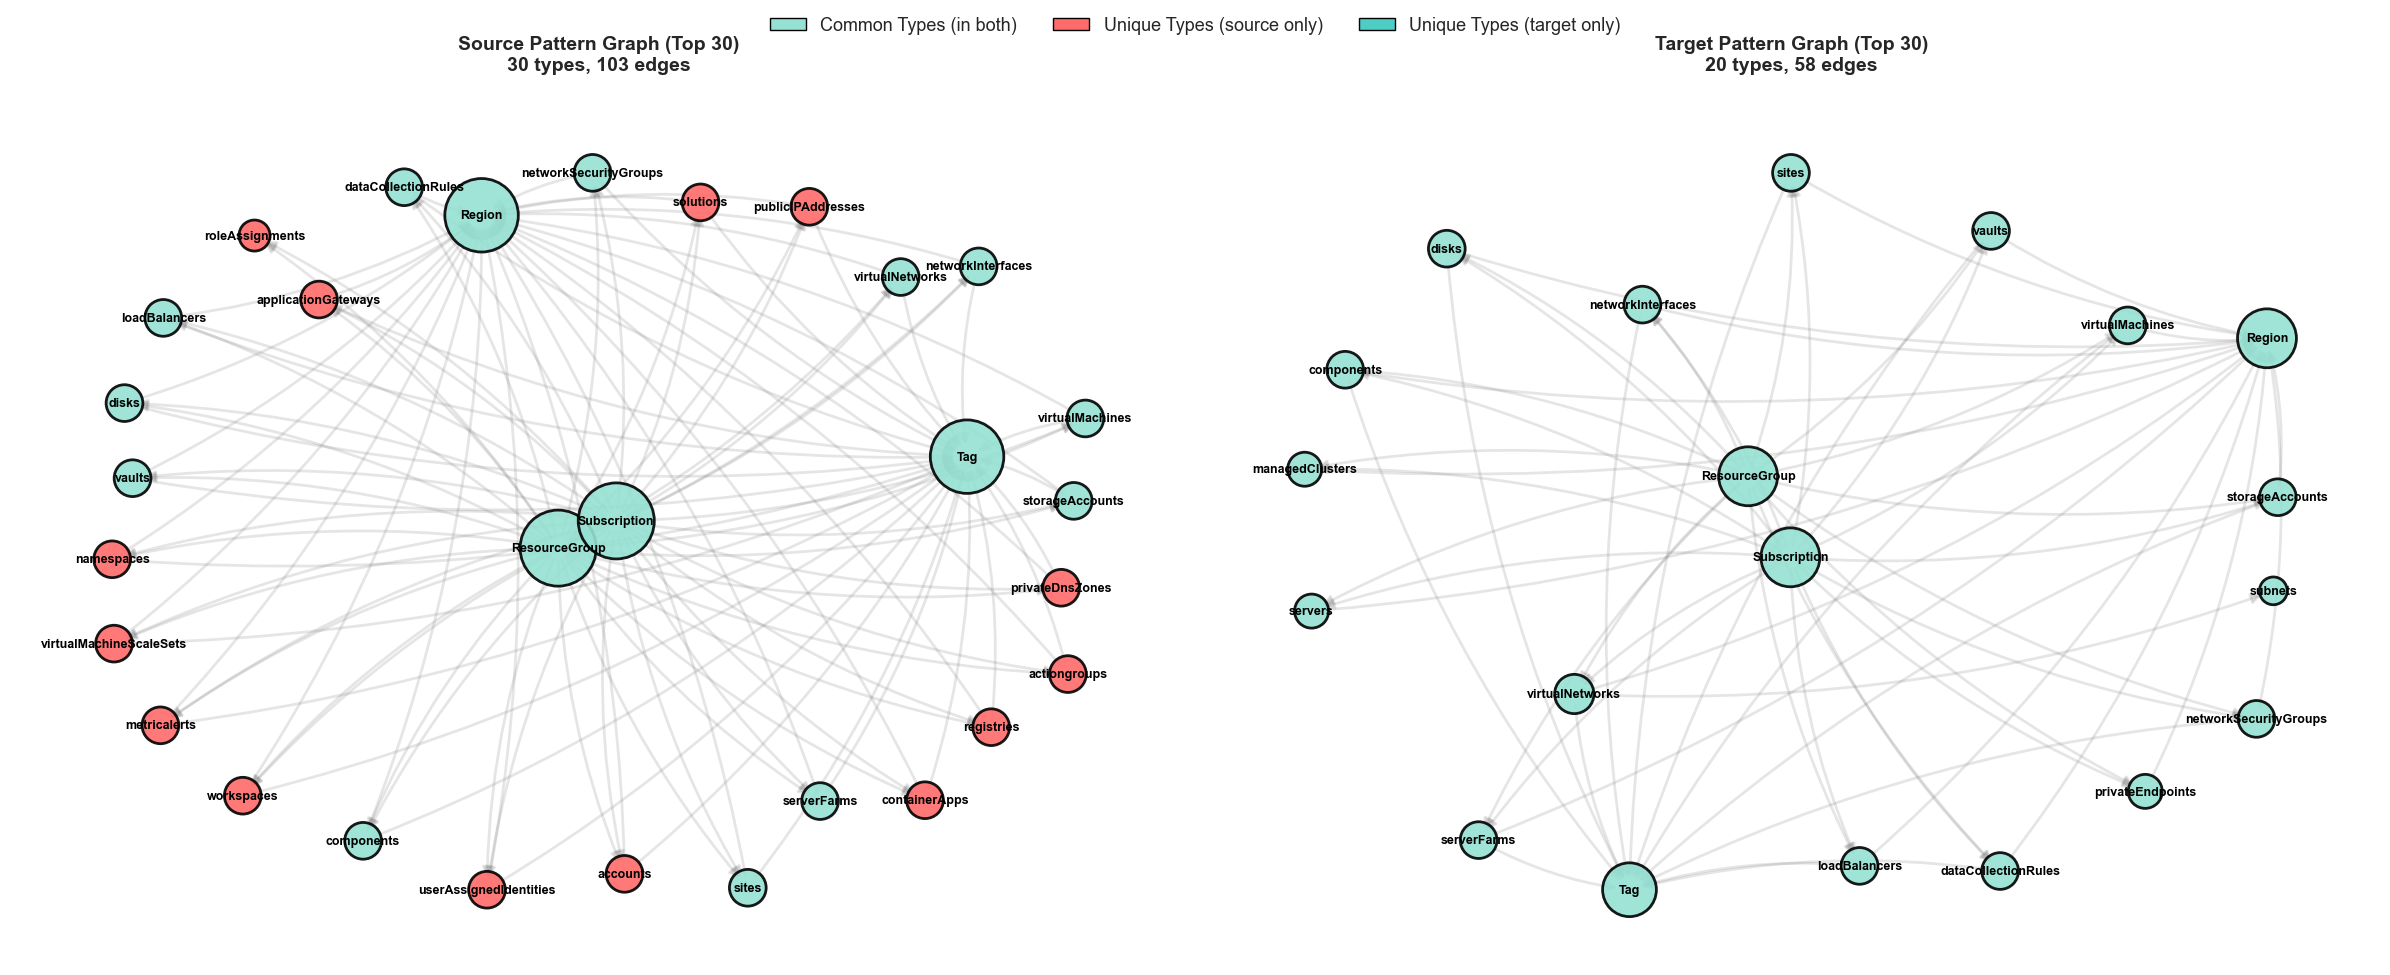


💡 Interpretation:
   • Teal nodes: Common resource types (captured in target)
   • Red nodes: Source-only types (not yet in target)
   • Larger nodes have higher degree (more connections)


In [8]:
# Limit to top nodes by degree for readability
TOP_N = 30

source_graph = replicator.source_pattern_graph
source_degrees = dict(source_graph.degree())
top_source_nodes = sorted(source_degrees.items(), key=lambda x: x[1], reverse=True)[
    :TOP_N
]
source_subgraph = source_graph.subgraph([n for n, _ in top_source_nodes]).copy()

target_degrees = dict(target_pattern_graph.degree())
top_target_nodes = sorted(target_degrees.items(), key=lambda x: x[1], reverse=True)[
    :TOP_N
]
target_subgraph = target_pattern_graph.subgraph([n for n, _ in top_target_nodes]).copy()

print(f"📊 Visualizing top {TOP_N} nodes by degree from each graph\n")

# Create side-by-side figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))


def draw_pattern_graph(G, ax, title, highlight_common=True):
    if G.number_of_nodes() == 0:
        ax.text(
            0.5,
            0.5,
            "No nodes",
            ha="center",
            va="center",
            transform=ax.transAxes,
            fontsize=16,
        )
        ax.set_title(title, fontsize=14, fontweight="bold")
        ax.axis("off")
        return

    # Layout
    pos = nx.spring_layout(G, k=2, iterations=50, seed=42)

    # Node sizes based on degree
    degrees = dict(G.degree())
    node_sizes = [degrees[node] * 100 + 300 for node in G.nodes()]

    # Node colors: highlight common nodes
    if highlight_common:
        node_colors = [
            "#95e1d3" if node in common_nodes else "#ff6b6b" for node in G.nodes()
        ]
    else:
        node_colors = [
            "#4ecdc4" if node in common_nodes else "#4ecdc4" for node in G.nodes()
        ]

    # Draw edges
    nx.draw_networkx_edges(
        G,
        pos,
        alpha=0.2,
        edge_color="gray",
        arrows=True,
        arrowsize=15,
        width=2,
        connectionstyle="arc3,rad=0.1",
        ax=ax,
    )

    # Draw nodes
    nx.draw_networkx_nodes(
        G,
        pos,
        node_size=node_sizes,
        node_color=node_colors,
        alpha=0.9,
        edgecolors="black",
        linewidths=2,
        ax=ax,
    )

    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=9, font_weight="bold", ax=ax)

    # Title
    stats = f"{G.number_of_nodes()} types, {G.number_of_edges()} edges"
    ax.set_title(f"{title}\n{stats}", fontsize=14, fontweight="bold", pad=20)
    ax.axis("off")


# Draw both graphs
draw_pattern_graph(source_subgraph, ax1, f"Source Pattern Graph (Top {TOP_N})", True)
draw_pattern_graph(target_subgraph, ax2, f"Target Pattern Graph (Top {TOP_N})", True)

# Add legend
from matplotlib.patches import Patch

legend_elements = [
    Patch(facecolor="#95e1d3", edgecolor="black", label="Common Types (in both)"),
    Patch(facecolor="#ff6b6b", edgecolor="black", label="Unique Types (source only)"),
    Patch(facecolor="#4ecdc4", edgecolor="black", label="Unique Types (target only)"),
]
fig.legend(
    handles=legend_elements,
    loc="upper center",
    ncol=3,
    fontsize=13,
    bbox_to_anchor=(0.5, 0.98),
)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

print("\n💡 Interpretation:")
print("   • Teal nodes: Common resource types (captured in target)")
print("   • Red nodes: Source-only types (not yet in target)")
print("   • Larger nodes have higher degree (more connections)")

---
# Summary
---

## Key Metrics

The visualizations above show:

1. **Architecture Distribution** - Target maintains proportional balance of source patterns
2. **Node Coverage** - Percentage of source resource types captured in target
3. **Graph Structure** - Visual comparison of pattern graph topology

## Interpretation

- **High distribution similarity** (cosine > 0.9) indicates proportional replication worked
- **High node coverage** (> 70%) indicates good resource type representation
- **Common nodes (teal)** show successfully captured patterns
- **Source-only nodes (red)** may need more instances to capture

## Configuration

To adjust coverage, modify `TARGET_INSTANCE_COUNT` in the configuration cell and re-run.